In [ ]:
#import libraries
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

(10, 1000, 2)
10


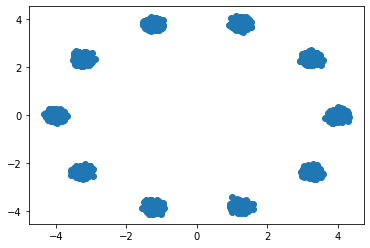

In [ ]:
def generate_2dgaussians(radius, N=10, num_data=1000, std=.1, origin=(0,0), tensor=False, seed=None):
    """Generates 2-dimensional Gaussians on a ring with given number of data points and dimensionality.
    Means of the Gaussians are located on the circle with given radius around the origin.

    Parameters
    ----------
        radius : {int, float}
            radius of the circle around the origin
        N : int
            number of Gaussians to generate, default is 10
        num_data : int
            number of data points to be generated for each Gaussian, default is 1000
        std : {int, float, numpy.ndarray}
            standard deviation of the Gaussians, can be float or ndarray,
            if float, all Gaussians have the same std,
            if ndarray, Gaussians have their own std, must have dim N
            default is 1.
        origin : array_like
            origin of the circle, default is (0,0)
        tensor : bool
            if True, output is a torch.tensor instead of numpy.ndarray, default is False
        seed : {None, int, array_like[ints], SeedSequence, BitGenerator, Generator}, optional
            seed for the RNG for repeating experiments, default is None
    Output
    ------
        gaussians : {numpy.ndarray, torch.tensor}
            ndarray/tensor of shape (N, num_data, 2)
    """
    # check types of inputs
    if type(std) is float or type(std) is int:
        std = np.full((N, 2), float(std))
    elif type(std) is not np.ndarray:
        raise ValueError("Parameter 'std' is not int, float or np.ndarray")

    if type(radius) is not float:
        if type(radius) is not int:
            raise ValueError("Parameter 'radius' is not float or int")
        radius = float(radius)

    # define variables
    dim = 2
    gaussians = np.zeros((N, num_data, dim))
    origin = np.array(origin)
    centers = np.zeros((N, dim))
    rng = np.random.default_rng(seed)

    # calculate Gaussian centers on circle and generate data for each
    for i in range(N):
        centers[i,0] = radius * np.cos((i*2*np.pi)/N) + origin[0]
        centers[i,1] = radius * np.sin((i*2*np.pi)/N) + origin[1]
        # generate num_data points for each of the Gaussians
        data = rng.normal(centers[i], std[i], (num_data, dim))
        gaussians[i] = data

    # return torch.Tensor instead of numpy.ndarray if desired
    if tensor:
        gaussians = torch.from_numpy(gaussians)
    return gaussians


ring_data = generate_2dgaussians(4)
#print(ring_data)
print(np.shape(ring_data)) 
    
    
print(len(ring_data))

plt.scatter(ring_data[:,:,0],ring_data[:,:,1])
#print(ring_data[0]) 


In [ ]:
latent_size = 16

# Discriminator
C = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
   

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, 32),
    nn.Tanh(),
    nn.Linear(32, 32),
    nn.Tanh(),
    nn.Linear(32, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
    )

In [ ]:

real_data = torch.FloatTensor(ring_data)
crit = C(real_data)
crit

tensor([[[-0.1074],
         [-0.1125],
         [-0.1179],
         ...,
         [-0.1126],
         [-0.1097],
         [-0.1094]],

        [[-0.1004],
         [-0.1232],
         [-0.1147],
         ...,
         [-0.1168],
         [-0.1123],
         [-0.1241]],

        [[-0.0213],
         [-0.0236],
         [-0.0255],
         ...,
         [-0.0369],
         [-0.0325],
         [-0.0343]],

        ...,

        [[-0.1324],
         [-0.1355],
         [-0.1210],
         ...,
         [-0.1299],
         [-0.1304],
         [-0.1353]],

        [[-0.1467],
         [-0.1575],
         [-0.1657],
         ...,
         [-0.1769],
         [-0.1794],
         [-0.1609]],

        [[-0.1494],
         [-0.1468],
         [-0.1537],
         ...,
         [-0.1478],
         [-0.1355],
         [-0.1458]]], grad_fn=<AddBackward0>)

In [ ]:
latent_size = 16

noise = torch.randn(1000, latent_size)
gen =G(noise)
gen

tensor([[ 0.0384,  0.0323],
        [-0.1406,  0.0110],
        [-0.1110,  0.0349],
        ...,
        [-0.2372, -0.0173],
        [-0.2586, -0.0068],
        [-0.1823,  0.0487]], grad_fn=<AddmmBackward>)

In [ ]:
lr = 5e-5


optimizer_G = torch.optim.RMSprop(G.parameters(), lr=lr)
optimizer_C = torch.optim.RMSprop(C.parameters(), lr=lr)


In [ ]:
def gradient_penalty(critic, real, fake):

    epsilon = torch.randn(1000, 2)
    interpolate = (real* epsilon) + (fake*(1- epsilon))
    score= critic(interpolate)

    gradient= torch.autograd.grad(outputs= score,
                                  inputs= interpolate,
                                  grad_outputs=torch.ones_like(score), #grad_outputs=fake, #grad_outputs=torch.ones_like(score),
                                  create_graph=True,
                                  retain_graph=True)[0]
  
  
  
    gradient= gradient.view(len(gradient), -1)
    gradient_norm= gradient.norm(2, dim=1)
    penalty = torch.nn.MSELoss()(gradient_norm, torch.ones_like(gradient_norm))
    return penalty #, gradient

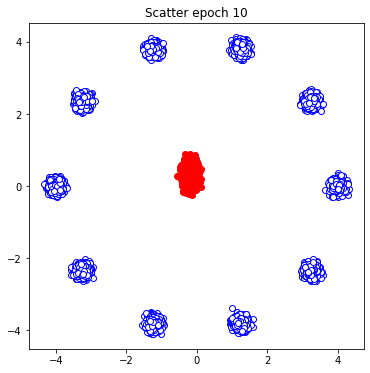

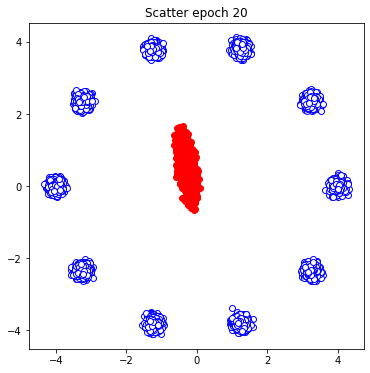

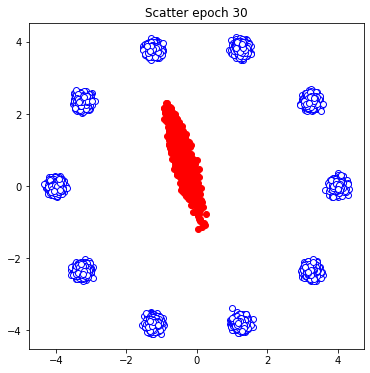

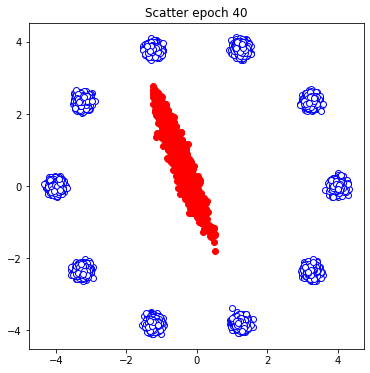

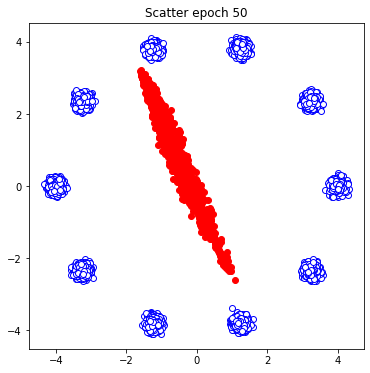

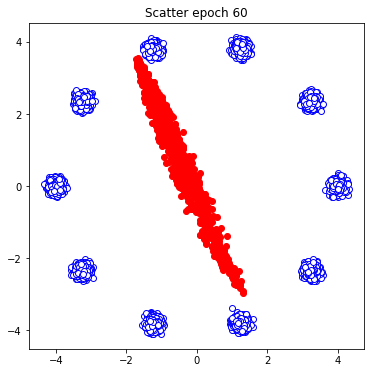

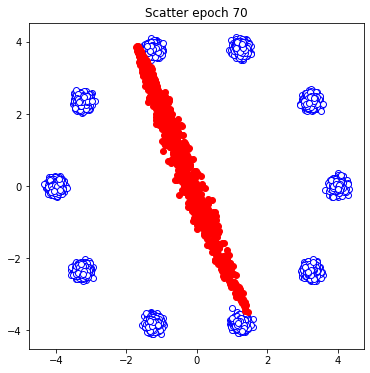

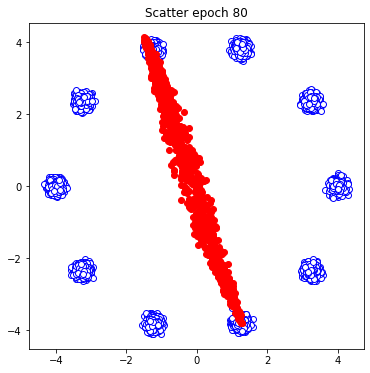

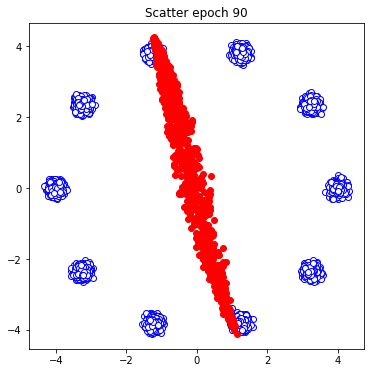

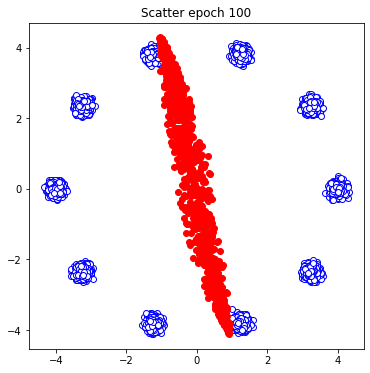

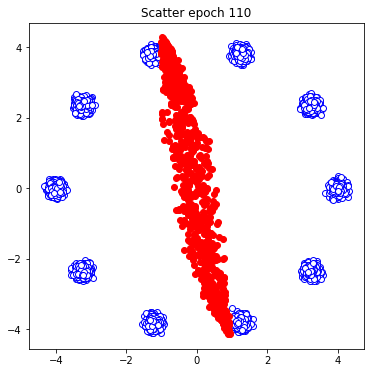

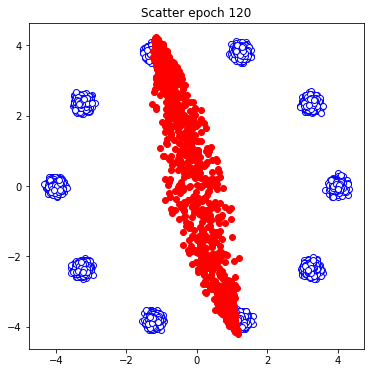

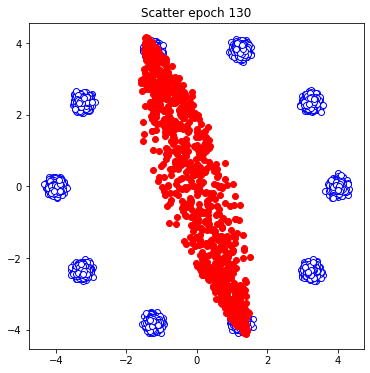

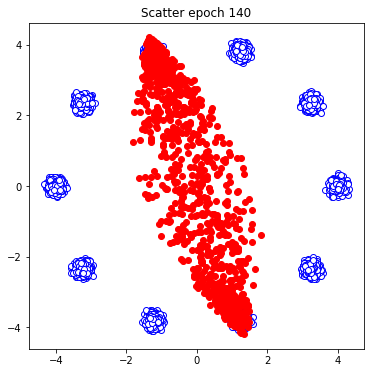

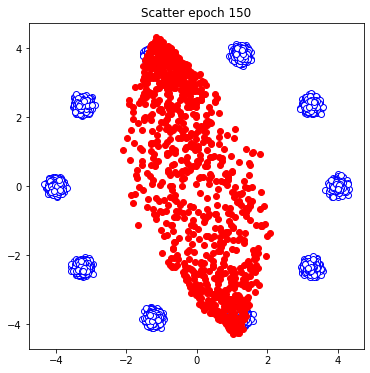

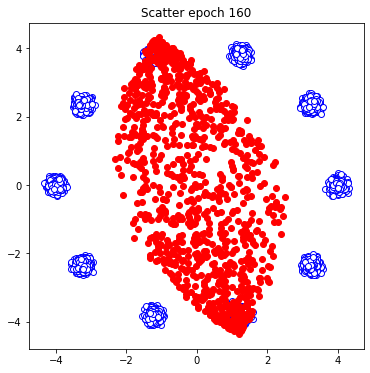

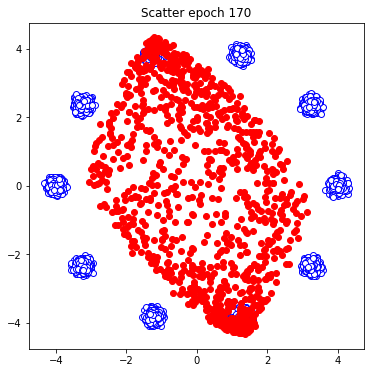

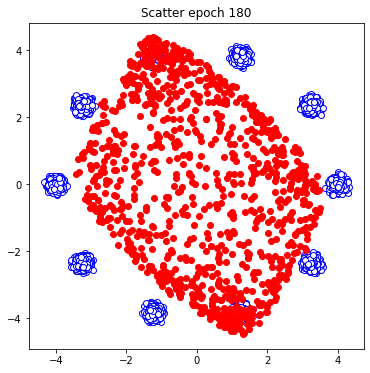

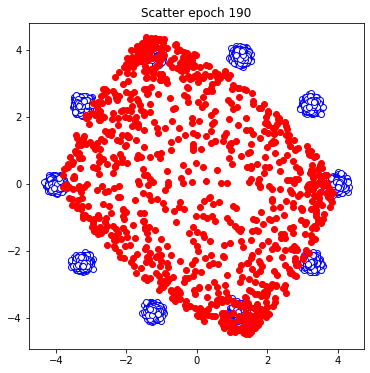

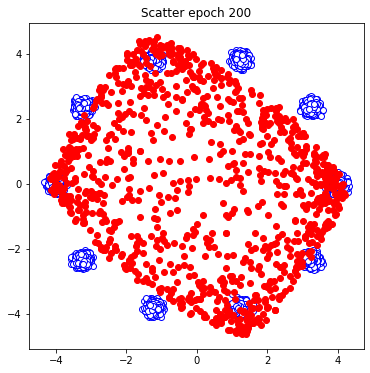

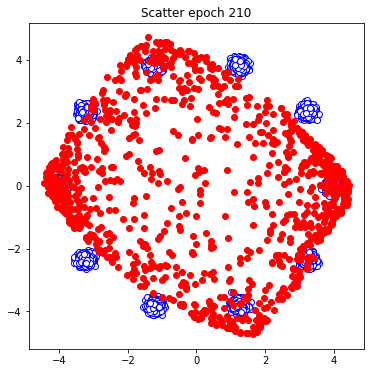

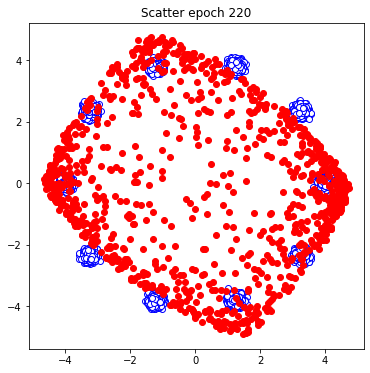

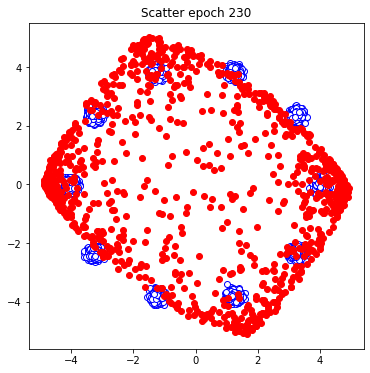

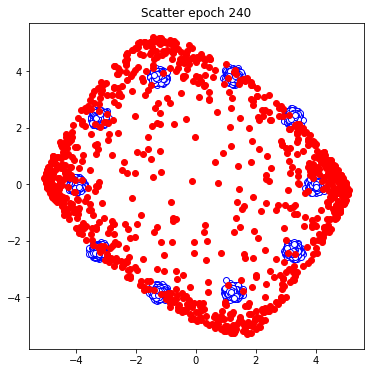

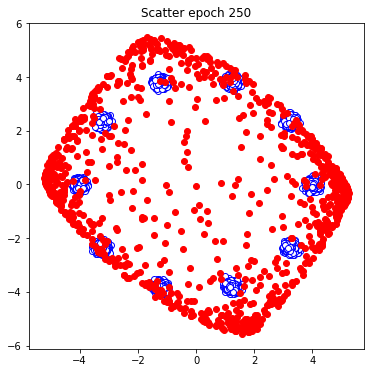

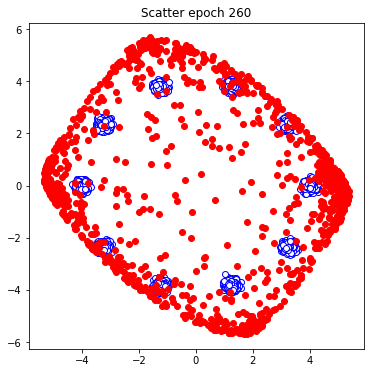

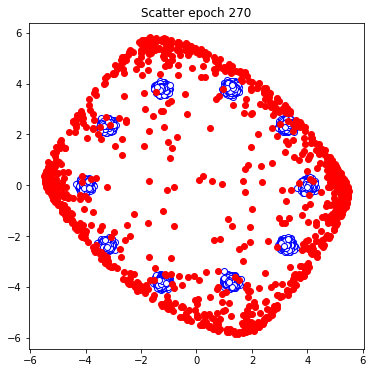

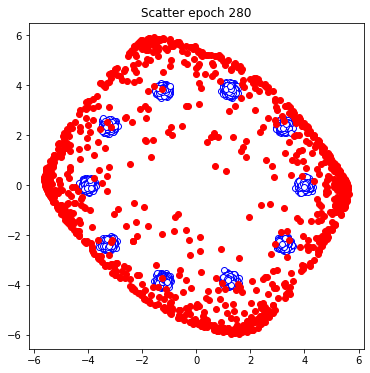

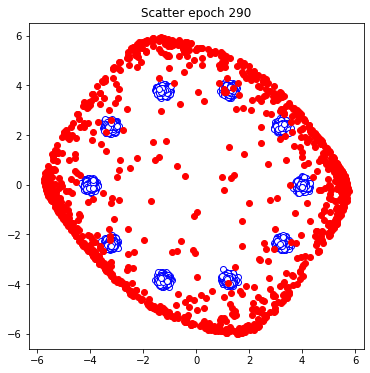

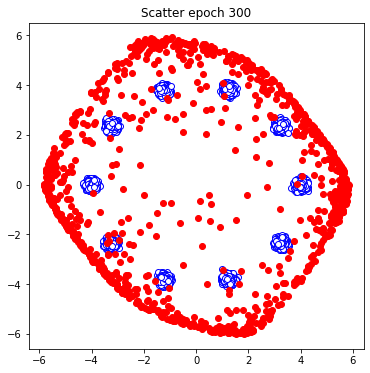

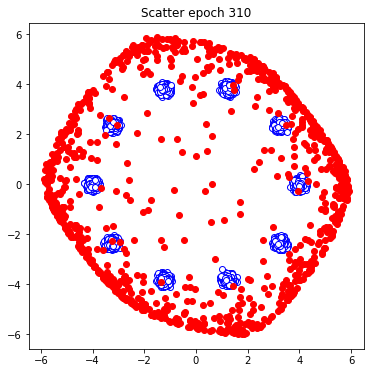

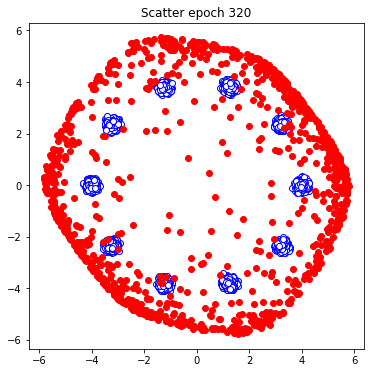

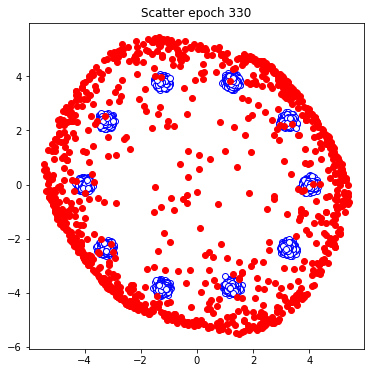

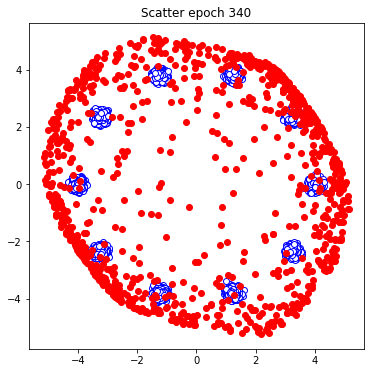

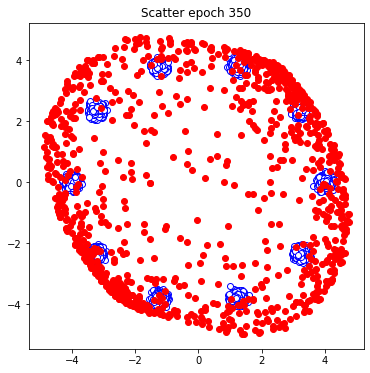

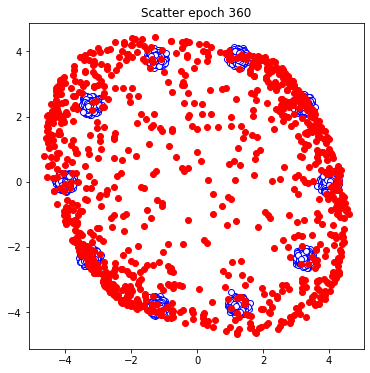

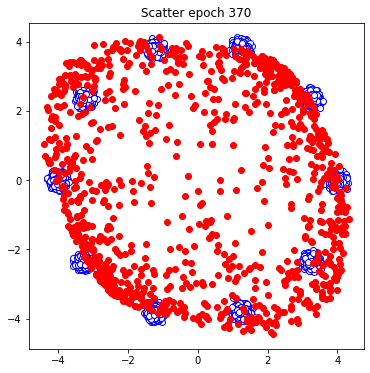

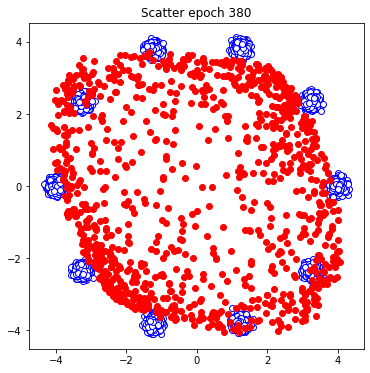

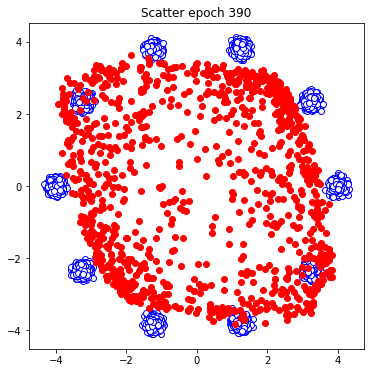

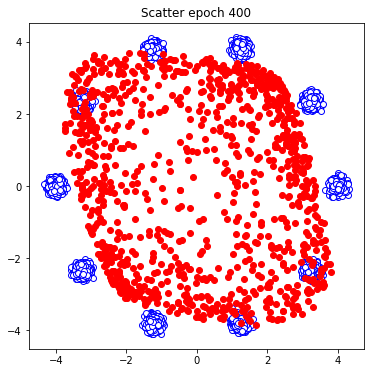

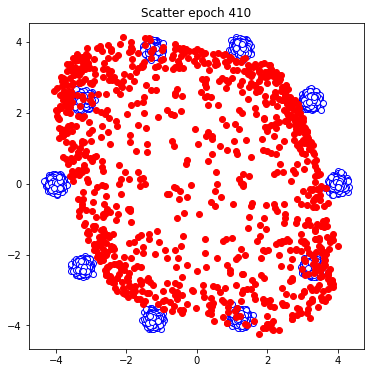

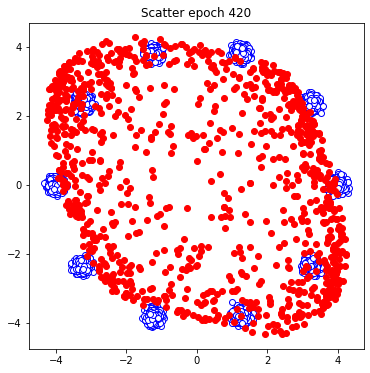

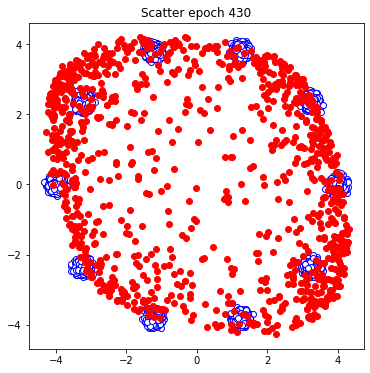

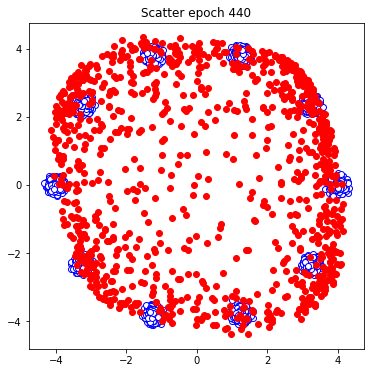

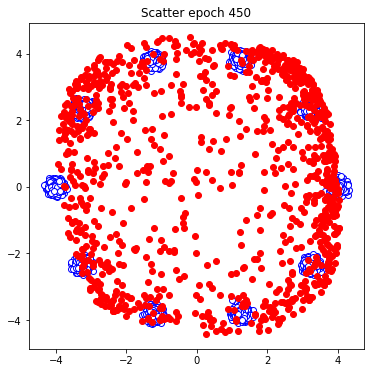

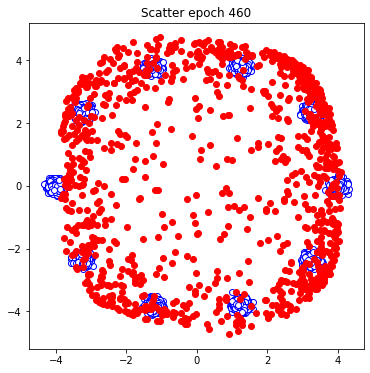

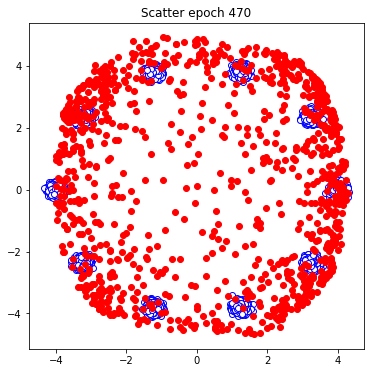

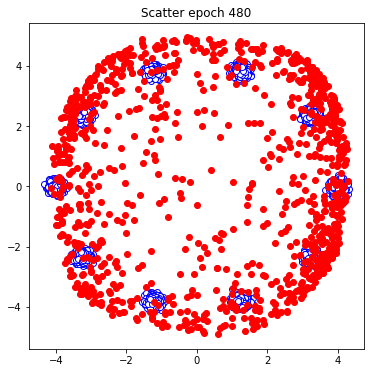

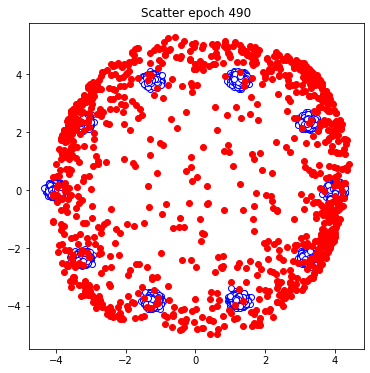

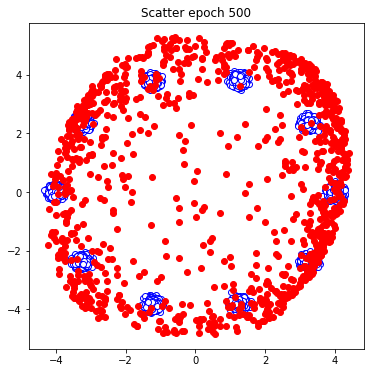

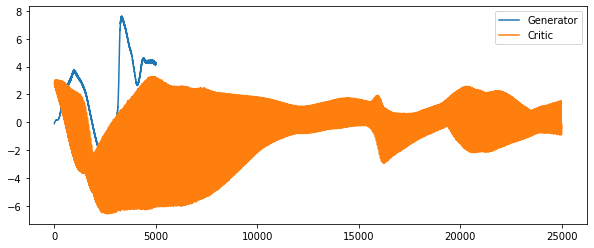

In [ ]:
# Start training
g_losses = []
c_losses = []
CRITIC_ITERATIONS =5
LAMBDA_GP = 3
#real = real_data
noise = torch.randn(1000, latent_size)
fake = noise
num_epochs = 500


for epoch in range(num_epochs):

    for i in range(real_data.shape[0]):
        #print(real_data[i])
        #print(len(real_data[i]))

        #training critic
        for _ in range(CRITIC_ITERATIONS):
            
            critic_real = C(real_data[i])
            fake_data = G(fake)
            critic_fake = C(fake_data)
        
            gp = gradient_penalty(C, real_data[i], fake_data)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            
            #crt.zero_grad()
            optimizer_C.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimizer_C.step()

            c_losses.append(loss_critic.item())
       
      
        
        
       #training generator
        gen_fake = C(fake_data)
        loss_gen = -torch.mean(gen_fake)
        optimizer_G.zero_grad()
        loss_gen.backward()
        optimizer_G.step()

        
        g_losses.append(loss_gen.item())
        
       
    
    if (epoch+1)%10==0:
        # Generate some fake data points from the generator sample
        z = torch.randn(1000, latent_size)
        with torch.no_grad():
            fake_data = G(z)
        fake_x,fake_y = fake_data[:,0].numpy(),fake_data[:,1].numpy()
        real_x,real_y = real_data[:,:,0].numpy(),real_data[:,:,1].numpy()

        step = 0.02
        x = np.arange(-2,2,step)
        y = np.arange(-2,2,step)

        #Turn the original data into grid data form
        X,Y = np.meshgrid(x,y)
        n,m = X.shape
        #Write function, z is uppercase

        inputs = torch.stack([torch.FloatTensor(X),torch.FloatTensor(Y)])
        inputs = inputs.permute(1,2,0)
        inputs = inputs.reshape(-1,2)
        with torch.no_grad():
            Z = C(inputs)
        Z = Z.numpy().reshape(n,m)
        
        #plt.figure(figsize=(7,6))
        #plt.title('Discriminator probablity')
        #cset = plt.contourf(X,Y,Z,100)
        #plt.colorbar(cset)
        #plt.show()
        
        plt.figure(figsize=(6,6))

        plt.scatter(real_x,real_y,c = 'w', edgecolor='b')
        plt.scatter(fake_x,fake_y,c = 'r')
        plt.title('Scatter epoch %d'%(epoch+1))
        #contour = plt.contour(X,Y,Z,1)
        #plt.clabel(contour,colors='k')
        plt.show()
        
plt.figure(figsize=(10,4))
plt.plot(g_losses,label='Generator')
plt.plot(c_losses,label='Critic')
plt.legend()

        
